<b>Verwendungshinweis: Dieses Jupyter Notebook ist ausschließlich für den internen Gebrauch bestimmt und darf weder an Dritte weitergegeben noch für eigene Schulungen, Veröffentlichungen etc. genutzt werden.</b>

---

# Zero Noise Extrapolation (ZNE)

The idea of zero noise extrapolation relies on the assumption that it is possible to increase the strength $\epsilon$ of noise in a quantum circuit, e.g., by introducing additional gates. 

Suppose we are interested in a certain quantity $F$ (e.g., an expectation value determined from the distribution of measurement results). If we determine the values $F(\epsilon_0)$, $F(\epsilon_1)$, $\dots$, for various noise strengths $\epsilon_0$, $\epsilon_1$, $\dots$, we can fit a smooth function to the corresponding data points, which we then extrapolate to the noise-free case $\epsilon=0$.


## Discrete case: insertion of identity gates

A more practical technique, which does not require the calibration of microwave pulses, consists of introducing additional gates into the circuit which, in the absence of errors, correspond to identity gates. Since, as discussed before, the main errors originate from imperfect CNOT gates, the simplest method is to replace each CNOT gate by 3 CNOT gates:  

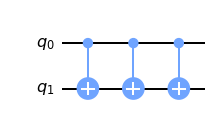

In [1]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(2)
qc.cx(0,1)
qc.cx(0,1)
qc.cx(0,1)
qc.draw('mpl')

(Remember that two CNOT gates correspond to the identity gate). Naively speaking, we expect that the error of the CNOT gate is increased by a factor 3. At least, this is true if the error of the CNOT gate is modelled by a depolarizing channel:

$$\mathcal{E}_{\rm noisy\ CNOT}(\rho) = (1-p) \mathcal{E}_{\rm ideal\ CNOT}(\rho) + \frac{p}{4}~I$$

since then:

$$\mathcal{E}_{\rm noisy\ CNOT}^3(\rho) = (1-p)^3 \mathcal{E}_{\rm ideal\ CNOT}(\rho) + 
\frac{1-(1-p)^3}{4}~I
\simeq (1-3p) \mathcal{E}_{\rm ideal\ CNOT}(\rho) + \frac{3p}{4}~I
$$

for small $p$ (since $\mathcal{E}_{\rm ideal\ CNOT}(I)=I$, as it is the case for every
unitary channel $\mathcal{E}_U(\rho)=U\rho U^\dagger$).

It is not true, however, in the general case. Nevertheless, the method can be applied in order to mitigate errors at least partially.

Similarly, replacing every CNOT gate with 5 CNOT gates increases the error by a factor 5, etc. However, if the error of the original circuit is already quite significant, a scaling of the error by a factor 3 (or larger) might be too much, since the extrapolation is expected to work well only in the regime of small errors. For this reason, we also need non-integer scaling factors (e.g., 1.1, 1.2, etc., depending on the strength of errors in the original circuit). Several proposal exist for how to do this, see, e.g., [Zero-noise extrapolation for quantum-gate error mitigation
with identity insertions](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.102.012426) by A. He et. al. and [Digital zero noise extrapolation for quantum error mitigation](https://ieeexplore.ieee.org/abstract/document/9259940) by T. Giurgica-Tiron et. al. In the following, we present a version developed by Finn Reinecke and Kathrin König based on these articles.

- For realizing scaling factors different from $1,3,5,\dots$, we replace every CNOT gate by a random number $r=1+2n$ of CNOT gates,  $c$ is achieved ($\langle r\rangle = c$). 

- In order to choose appropriate scaling factors, we need some information concerning the strength of errors in the original circuit. For this purpose, we take the average error rates of CNOT gates as provided by the calibration data and define a quantity called "expected total error strength" $x_0$ as the sum of the average error rates of each CNOT gate occurring in the original circuit. We then choose scaling factors $c_i$ such that
$c_i x_0\in [x_0,x_0+a]$, where the default value of the parameter $a$ is chosen as $a=1$. We
take a certain number (default value: order + 3) of scaling factors equally spaced in this interval.

- For each scaling factor $c_i$, we randomly generate 5 (default) different circuits with this scaling factor and run each of them with a certain number of shots for a total of 10000 (default). From the distribution of measurement results, we determine the mean value of the function $F$ that we are interested in.

- A polynomial function of a certain degree (default value: 2) is fitted to the data points $F(c_1)$, $F(c_2)$, $F(c_3)$, $\dots$ and finally evaluated for the noise-free case ($c=0$).

This procedure is performed with a class named ZNE. On an instance of this class (for example `my_zne = ZNE()`) we can perform the following steps to get through the whole process of a ZNE:
- Transpilation with the method `ZNE.transpile`
- Folding (extending the transpiled circuit by the extra CNOT gates) with `ZNE.fold_circs`
- Running circuits with `ZNE.get_expectations`
- Fitting a function through the acquired datapoints by `ZNE.fit`

Note that each of these steps can be done with either the given method or it can be replaced by a self written function or class. So there is plenty of room for combinations, experiments and extensions. You just need to remember to adjust the functions of the ZNE class properly.

We will demonstrate the zero noise extrapolation for the HHL-algorithm with 4 qubits, see
https://qiskit.org/textbook/ch-applications/hhl_tutorial.html.
This algorithms solves a two-dimensional, linear system of equations. The function $F$ that we are interested in is the norm of the corresponding solution.

The module ```algorithm``` contains the function `algo` generating the quantum circuit of the HHL algorithm and the function ```eval_counts``` corresponding to the above function $F$. The module ```zne```contains the class ZNE needed to perform the zero noise extrapolation. 

In the following we will use a FakeBackend as provided by qiskit. It can be replaced by any other backend or simulator.

In [2]:
import matplotlib.pyplot as plt
from algorithm import algo, eval_counts
from zne import ZNE
from qiskit.test.mock import FakeLagos

In [3]:
fakebackend = FakeLagos()
my_zne = ZNE()
qc = algo()

In the first example we will only use our circuit qc, the chosen backend and the evaluation function `eval_counts` as input. The class will now choose a set of scaling factors based on the backends noise model by the described procedure with the parameter a=1.

In [4]:
qc_transpiled = my_zne.transpile(qc, fakebackend)
qcs_folded = my_zne.fold_circs(qc_transpiled)
expectations, counts = my_zne.get_expectations(qcs_folded, eval_counts=eval_counts)
result, params, residuals = my_zne.fit()
print(result)

1.1860466782782584


Afterwards the extrapolation can be plotted. Simply create a figure and use the method `my_zne.plot()`.

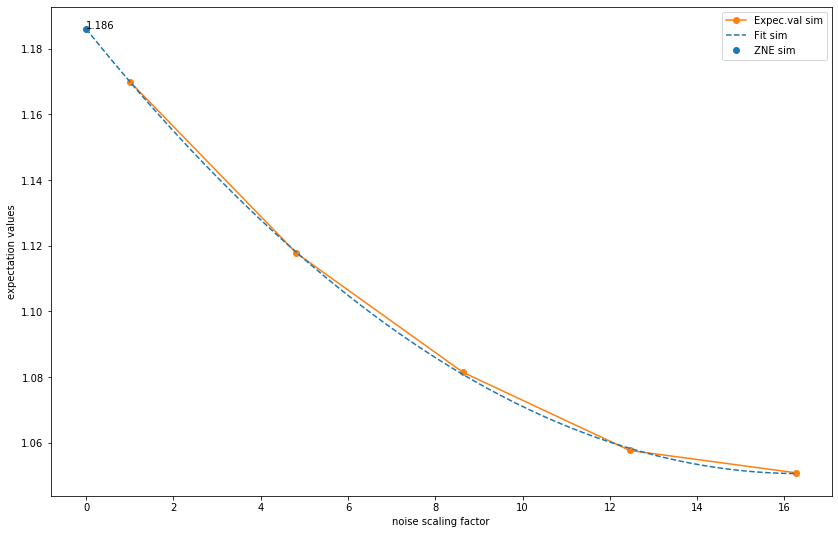

In [5]:
plt.figure(figsize=[14,9])
my_zne.plot(label="sim")

The exact value determined from noise-free simulation is 1,185854123

To make this whole process a little more transparent in the following the same code is extended by inputs that were made automatically.
The changes are:
- line 4: getting the chosen n-values out of the class, to later use them in the fit
- line 6: if you want to transpile for a physical backend but run on a simulator, you can give a different but compatibel (!) backend in `ZNE.get_expecations()`
- line 8: arguemnts wich can be added to the fit function are x, y values which have to be fitted and the type of fit (fit_method = "pol" or "exp) as well as the order. You can change the fitting method from "pol" to "exp" with a linear polynom (order=1) as argument for the exponential function. Note that this might be less stable and you can encounter `nan` values.

In [6]:
qc_transpiled = my_zne.transpile(qc, fakebackend)

qcs_folded = my_zne.fold_circs(qc_transpiled)
n_vals = my_zne.real_n_vals

expectations, counts = my_zne.get_expectations(qcs_folded, eval_counts=eval_counts, backend=fakebackend)

result, params, residuals = my_zne.fit(x=n_vals, y=expectations, order=2, fit_method="pol")

print(result)

1.1804905338142486


## Specify scaling factors
An own set of scaling factors can be specified as input to the folding step `fold_circs`.

In [7]:
my_n_vals = [0, 1, 2, 3]
zne_own_n_vals = ZNE()

In [8]:
qc_transpiled = zne_own_n_vals.transpile(qc, fakebackend)

qcs_folded = zne_own_n_vals.fold_circs(qc_transpiled, n_vals=my_n_vals)

expectations, counts = zne_own_n_vals.get_expectations(qcs_folded, eval_counts=eval_counts, backend=fakebackend)

result, params, residuals = zne_own_n_vals.fit(x=my_n_vals, y=expectations, order=2, fit_method="pol")

print(result)

1.1843201141764153


## Measurement Mitigation 
### tensored
To include a measurement mitigation in this process you can either use the integrated way (see below) or just take the counts returned from the `ZNE.get_expectations` method and perform your own measurement mitigation.

In [9]:
zne_mit = ZNE()

In [10]:
qc_transpiled = zne_mit.transpile(qc, fakebackend)

qcs_folded = zne_mit.fold_circs(qc_transpiled)
n_vals = zne_mit.real_n_vals

expectations, counts = zne_mit.get_expectations(qcs_folded, eval_counts=eval_counts, mitigation="tensored")

result, params, residuals = zne_mit.fit(x=n_vals, y=expectations, order=2, fit_method="pol")

result_raw, _, _ = zne_mit.fit(x=n_vals, y=zne_mit.raw_expect_vals, order=2, fit_method="pol")
print("Deviation from analytical result:")
print("mitigated and extrapolated:", abs(1.185854123 - result))
print("extrapolated:              ", abs(1.185854123 - result_raw))

Deviation from analytical result:
mitigated and extrapolated: 0.007201978058009706
extrapolated:               0.009689953451258448


### mthree
To use the mthree method for the measurement mitigation simply write `mitigation="mthree"` as an argument.

<b>Note:</b> 
    This method will result in an extra call to a physical backend. Hence the job queue will be passed through two times!

In [11]:
zne_mthree = ZNE()

In [12]:
qc_transpiled = zne_mthree.transpile(qc, fakebackend)

qcs_folded = zne_mthree.fold_circs(qc_transpiled)
n_vals = zne_mthree.real_n_vals

expectations, counts = zne_mthree.get_expectations(qcs_folded, eval_counts=eval_counts, mitigation="mthree")

result, params, residuals = zne_mthree.fit(x=n_vals, y=expectations, order=2, fit_method="pol")

result_raw, _, _ = zne_mthree.fit(x=n_vals, y=zne_mthree.raw_expect_vals, order=2, fit_method="pol")
print("Deviation from analytical result:")
print("mitigated and extrapolated:", abs(1.185854123 - result))
print("extrapolated:              ", abs(1.185854123 - result_raw))

Deviation from analytical result:
mitigated and extrapolated: 0.0071723699561412335
extrapolated:               0.009760732098444302


## eval_counts
A proper example for an eval_counts function could give the probability of the last measured qubit in 0.
In the end it just expresses what you want to do with the returned counts, condensed into a value to make ZNE possible.

In [13]:
def eval_counts1(counts):
    p0 = 0
    shots = 0
    for i in counts:
        if i[0] == "0":
            p0 += counts[i]
        shots += counts[i]
    p0 /= shots
    return p0

## Usaging multiple expectation values
This is an example to perform ZNE for multiple expectation values at once. `eval_counts` has to return a list of wanted expectation values.
If we are interested in two different probabilities, `eval_counts` can be written like the following:

In [14]:
def eval_counts2(counts):
    p0 = 0
    p1 = 0
    shots = 0
    for i in counts:
        if i[0] == "0":
            p0 += counts[i]    
        if i[0] == "1":
            p1 += counts[i]
        shots += counts[i]
    p0 /= shots
    p1 /= shots
    return [p0,p1]

Now we can perform a zero noise extrapolation on our noisy simulator.

In [16]:
zne_eval_counts = ZNE()
n_vals = [0,1,2,3]
qc_transpiled = zne_eval_counts.transpile(qc, fakebackend)

qcs_folded = zne_eval_counts.fold_circs(qc_transpiled, n_vals=n_vals)
n_vals = zne_eval_counts.real_n_vals

expectations, counts = zne_eval_counts.get_expectations(qcs_folded, eval_counts=eval_counts2, mitigation="mthree")

result, params, residuals = zne_eval_counts.fit(x=n_vals, y=expectations, order=1, fit_method="exp")

print(result)

[0.4321173472548842, 0.617515824562456]


Since we initially took the probability of the last measured qubit in 0 as p0 and the same qubit in 1 as p1, the sum of the two resulting values give roughly 1 but not necessary exactly 1!

<b>So be aware that after the zero noise extrapolation there won't be a proper probability distribution!</b>

## Saving to json
As default the extrapolation will save the results of the extrapolation in `ZNEdata/data_DATE.json` where DATE is the date in local time. The filename can be changed by giving the argument `file=my_file` and the directory by `dirpath=my_dir`.
Information like backend, mitigated counts, inital layout, mitigation method, ect. will be saved.

In [17]:
zne_json = ZNE()
qc_transpiled = zne_json.transpile(qc, fakebackend)

qcs_folded = zne_json.fold_circs(qc_transpiled)
n_vals = zne_json.real_n_vals

expectations, counts = zne_json.get_expectations(qcs_folded, eval_counts=eval_counts, mitigation="mthree")

result, params, residuals = zne_json.fit(x=n_vals, y=expectations, order=2, fit_method="pol")

zne_json.save_json(file="test.json", dirpath="", overwrite=True)
print(result)

1.1867801993827198


For later usage or visualization the old experiment can be reinstanciated by the `from_json` method.

In [18]:
zne_json2 = ZNE()
zne_json2.from_json("test.json")

## Plot the results
For a quick visualization you can use the `plot` method. Simply create a figure and use the method `plot()`. By default it will plot the measurement mitigated value (or the non-mitigated if no measurement mitigation was done). If you want to take the non-mitigated one give the argument `mit=False`.

For usage with multiple expectation values: This will automatically plot the noiseless version of the first value returned by the function $F$ (corresponding to the argument `model=0`). To plot the noiseless version of the $n^{th}$ return value of $F$ just set `model=n`.

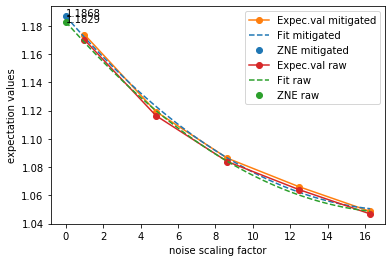

In [19]:
plt.figure()
zne_json2.plot(mit=True, label='mitigated')
zne_json2.plot(mit=False, label='raw')

Note that since the measurement errors are rather small for some devices (and hence for their noise models too) the two plotted lines can be quite similar.

Ihr Kontakt zu den Erstellern dieses Jupyter Notebooks:

- Kathrin König: kathrin.koenig@iaf.fraunhofer.de

© Fraunhofer IAF

In [22]:
import qiskit.tools.jupyter
%qiskit_version_table

**Copyright 2023 Kathrin König, Fraunhofer IAF**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.